# **Deep Recommend**

In [0]:
ff = 'ratings.dat'

In [30]:
name = ['user', 'item', 'rating', 'time']
dff = pd.read_csv(ff, sep='::', names = name)
dff = dff.drop(columns = ['time'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [31]:
dff.head()

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [0]:
data_dim = len(dff.user.unique()), len(dff.item.unique())

In [33]:
data_dim

(6040, 3706)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
data = np.array(dff)
train, test = train_test_split(data, test_size=0.2)

In [0]:
u_train = train[:,0]
i_train = train[:,1]
r_train = train[:,2]
u_test = test[:,0]
i_test = test[:,1]
r_test = test[:,2]

In [0]:
# r_train = r_train/5
# r_test = r_test/5

In [0]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import dot, concatenate, Embedding, Input, Flatten, Dropout, Dense, add
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [0]:
len_dim_i = [100,200,300]
len_dim_u = [100,200,300]
len_dim_r = [300,200,100]

In [0]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

user_embedding = Embedding(output_dim=10, input_dim=data_dim[0] + 1,
                                   input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=10, input_dim=data_dim[1] + 1,
                                   input_length=1, name='item_embedding')(item_id_input)
#user-item init
# user_layer = (Dense(100, activation="relu"))(user_id_input)
# item_layer = (Dense(100, activation="relu"))(item_id_input)
# sub_layer_user = add([user_embedding, user_id_input])
# sub_layer_item = add([item_embedding, item_id_input])


# user_embedding = (Dense(100, activation="relu"))(user_embedding)
# item_embedding = (Dense(100, activation="relu"))(item_embedding)
# sub_layer_user = (Dense(100, activation="relu"))(sub_layer_user)
# sub_layer_item = (Dense(100, activation="relu"))(sub_layer_item)

# for i in range(len(len_dim_u)):
#     user_embedding = (Dense(len_dim_u[i], activation="relu"))(user_embedding)
#     user_embedding = (Dropout(0.1))(user_embedding)
# for i in range(len(len_dim_i)):
#     item_embedding = (Dense(len_dim_i[i], activation="relu"))(item_embedding)
#     item_embedding = (Dropout(0.1))(item_embedding)

# sub_layer_user = add([user_embedding, user_layer])
# sub_layer_item = add([item_embedding, item_layer])
#1st block
user_embedding = (Dense(100, activation="relu"))(user_embedding)
item_embedding = (Dense(100, activation="relu"))(item_embedding)

sub_layer_user = (Dense(100, activation="relu"))(user_id_input)
sub_layer_item = (Dense(100, activation="relu"))(item_id_input)
#xcep
sub_layer_user = add([user_embedding, sub_layer_user])
sub_layer_item = add([item_embedding, sub_layer_item])

user_embedding = (Dense(150, activation="relu"))(user_embedding)
item_embedding = (Dense(150, activation="relu"))(item_embedding)

sub_layer_user = (Dense(150, activation="relu"))(user_id_input)
sub_layer_item = (Dense(150, activation="relu"))(item_id_input)
#xcep
sub_layer_user = add([user_embedding, sub_layer_user])
sub_layer_item = add([item_embedding, sub_layer_item])

#2nd block
user_embedding = (Dense(200, activation="relu"))(user_embedding)
item_embedding = (Dense(200, activation="relu"))(item_embedding)

sub_layer_user = (Dense(200, activation="relu"))(sub_layer_user)
sub_layer_item = (Dense(200, activation="relu"))(sub_layer_item)

user_embedding = add([user_embedding, sub_layer_user])
item_embedding = add([item_embedding, sub_layer_item])

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

    
# y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
y = concatenate([user_vecs, item_vecs])
# # y = (Dense(1, activation="relu"))(y)
for i in range(len(len_dim_r)):
    y = (Dense(len_dim_r[i], activation="relu"))(y)
    y = (BatchNormalization())(y)
    y = (Dropout(0.2))(y)
# y = Dense(1, activation="relu")(y)
# M = Sequential()
# M.add(y)
# y = (Dropout(0.25))(y)
# y = (Dense(64))(y)
# y = (Dropout(0.2))(y)
# y = (Dense(32))(y)
# y = (Dropout(0.25))(y)
# y = (Dense(16))(y)
# y = (Dropout(0.1))(y)
# y = (Dense(4))(y)
# y = (Dropout(0.2))(y)
y = (Dense(1, activation='relu'))(y)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mae', metrics=['mse'])

In [65]:
history = model.fit([u_train,i_train], r_train,validation_data=([u_test,i_test], r_test), batch_size=64, epochs = 5, verbose=1, shuffle=True)

Train on 800167 samples, validate on 200042 samples
Epoch 1/5
800167/800167 [==============================] - 243s 303us/step - loss: 1.1108 - mean_squared_error: 2.1071 - val_loss: 0.9395 - val_mean_squared_error: 1.3683
Epoch 2/5
800167/800167 [==============================] - 236s 295us/step - loss: 0.9641 - mean_squared_error: 1.5643 - val_loss: 0.8977 - val_mean_squared_error: 1.3118
Epoch 3/5
800167/800167 [==============================] - 235s 293us/step - loss: 0.8984 - mean_squared_error: 1.3235 - val_loss: 0.9282 - val_mean_squared_error: 1.3200
Epoch 4/5
800167/800167 [==============================] - 235s 294us/step - loss: 0.8378 - mean_squared_error: 1.1313 - val_loss: 0.9236 - val_mean_squared_error: 1.2557
Epoch 5/5
800167/800167 [==============================] - 235s 294us/step - loss: 0.8030 - mean_squared_error: 1.0442 - val_loss: 1.6512 - val_mean_squared_error: 13398.3913


In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60410       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        37070       item[0][0]                       
__________________________________________________________________________________________________
add_75 (Ad

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

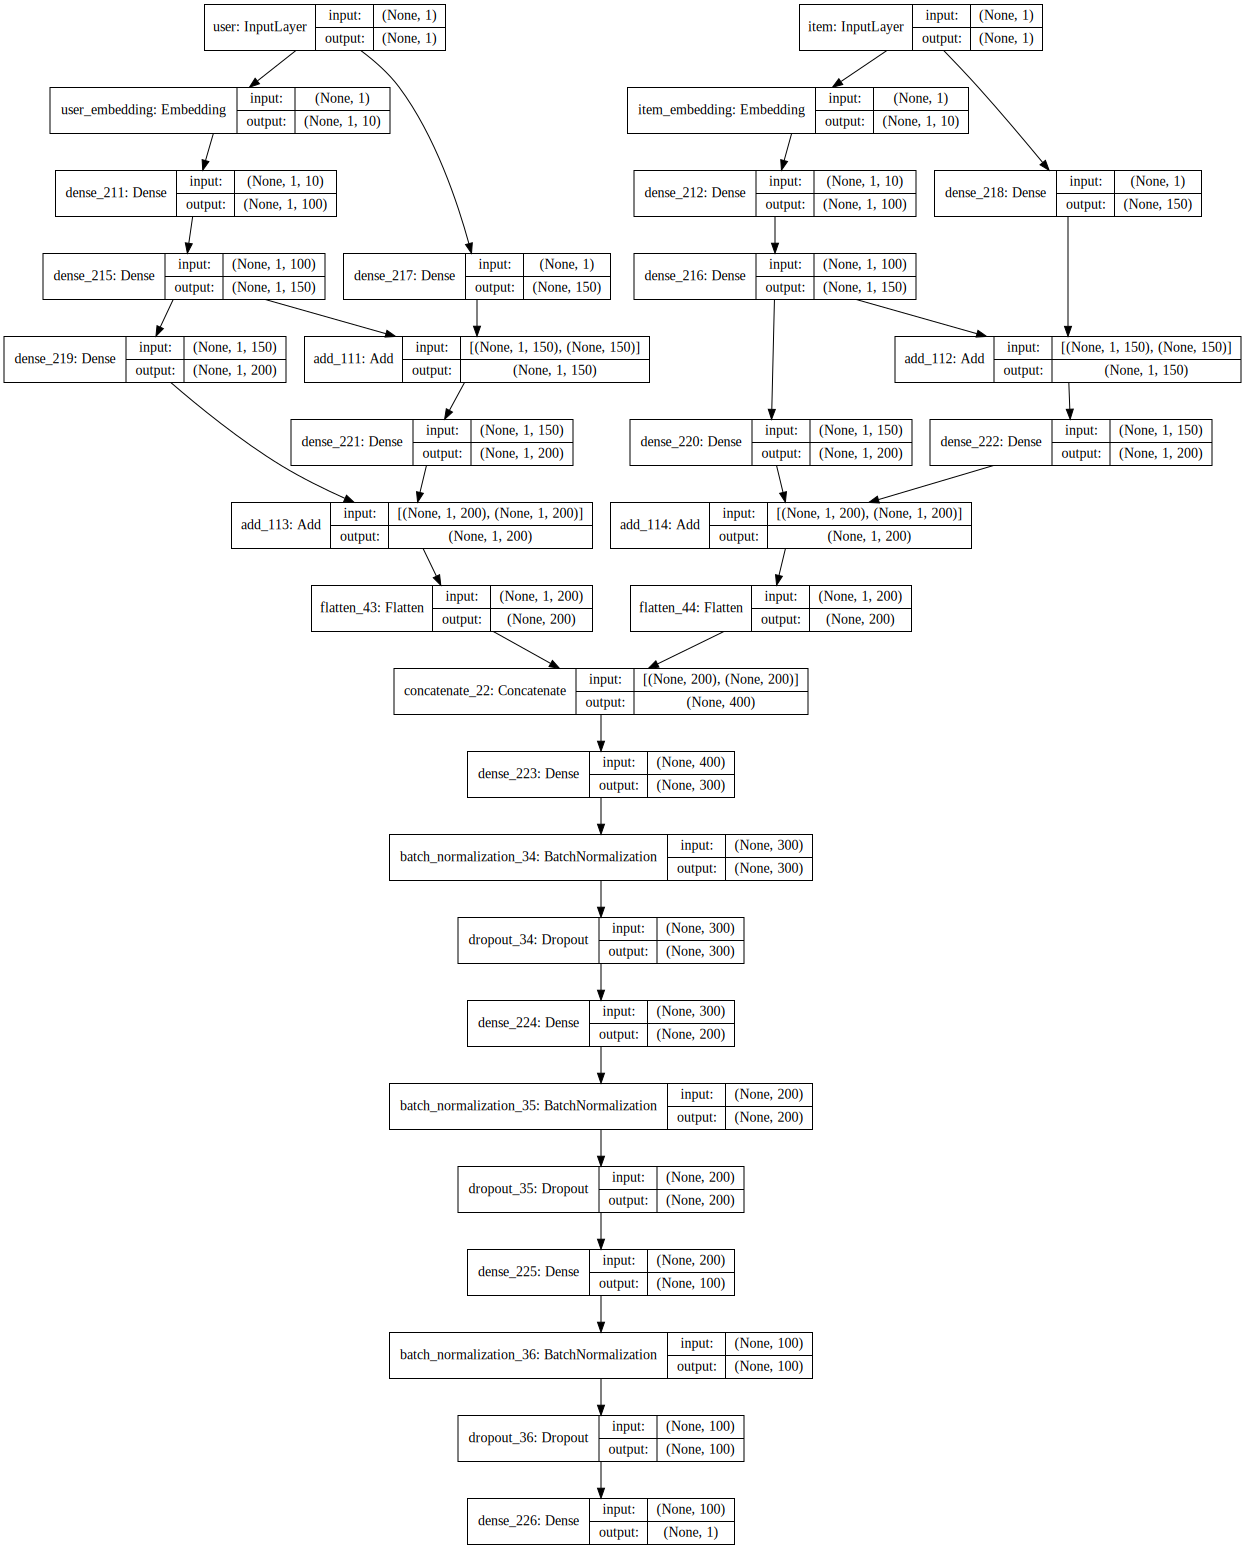

In [66]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
# print(history)

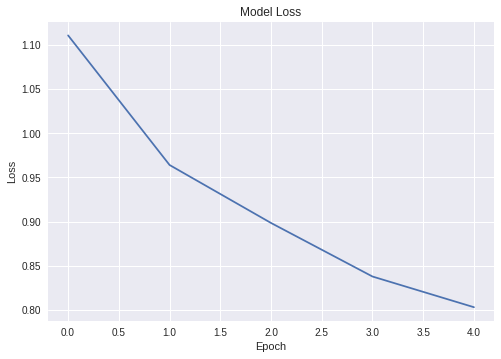

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Save Model

In [0]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
model1 = load_model('my_model.h5')